# Hierarchical clustering
---

This is an example routine to perform hierarchical clustering on an IRIS-like raster.

## Modules

In [1]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

# Sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA
import sklearn.preprocessing as preprocessing

# Scipy
from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Extras
import random
import time
import tqdm
import os
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

## Functions

In [2]:
def gaussian(x, mu, sig):
    """
        Gaussian definition.
    """
    return (1.0/(sig*np.sqrt(2.0*np.pi)))*np.exp( -0.5*((x-mu)/sig)**2.0 )

##  IRIS fake spectra

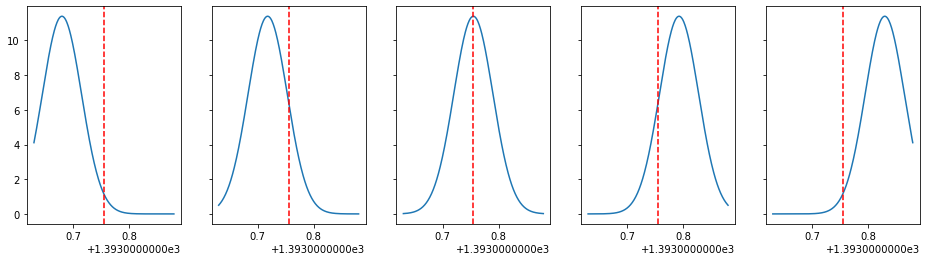

In [3]:
#-------------------------------------------------------------------
# INPUT PARAMETERS
#-------------------------------------------------------------------
n_profiles = 5           # N. of Si IV profiles
sigma      = 0.035        # Sigma of the Gaussian  
doppl_sh   = 0.03       # Angstroms separation between profiles
nw         = 324         # N. of elements for the wavelength array
w0         = 1393.755    # Wavelength at rest
wd         = 0.25         # Width in Angstroms centered at w0
wi         = w0-wd/2.    # Lower limit of the wavelength array
wf         = w0+wd/2.    # Upper limit of the wavelength array

#-------------------------------------------------------------------
# CREATION OF PROFILES
#-------------------------------------------------------------------
iris_wl    = np.linspace(wi, wf, num=nw) 
ww         = doppl_sh*np.linspace(-n_profiles/2.0,n_profiles/2.0,
                                  n_profiles)
ff         = np.zeros((nw,n_profiles))

for kk in range(n_profiles):
    ff[:,kk] = gaussian(iris_wl, w0+ww[kk], sigma)

    
#-------------------------------------------------------------------
# PLOT
#-------------------------------------------------------------------
fig, axs = plt.subplots(1, n_profiles, figsize=(16,4), 
                        facecolor='white',sharex=True, sharey=True)
for kk in range(n_profiles):
    axs.flat[kk].plot(iris_wl,ff[:,kk])
    axs.flat[kk].axvline(w0,linestyle="dashed",color="r")
plt.show()

## IRIS fake raster

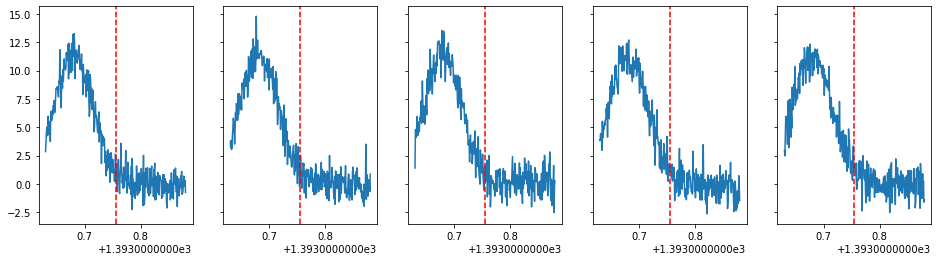

In [4]:
#-------------------------------------------------------------------
# IRIS RASTER PARAMETERS
#-------------------------------------------------------------------
noise    = 1.0
filly    = 10                      # N rows for each profile
ny       = n_profiles*filly        # Y size of the IRIS raster
nx       = 64                      # X size of the IRIS raster
raster_m = np.zeros((nx, ny, nw))  # IRIS raster initialization

#-------------------------------------------------------------------
# FAKE RASTER WITH NOISE
#-------------------------------------------------------------------
ll = -1
for jj in range(ny):
    if (jj % filly == 0):
        ll+=1 
    for ii in range(nx):
        raster_m[ii,jj,:] = ff[:,ll] + \
                            noise*norm.ppf(np.random.rand(nw))

#-------------------------------------------------------------------
# EXAMPLE OF PROFILES WITH NOISE
#-------------------------------------------------------------------
fig, axs = plt.subplots(1,n_profiles,figsize=(16,4), 
                        facecolor='white',sharey=True)

ex  = np.arange(0,ny,filly)
for kk in range(n_profiles):
    axs.flat[kk].plot(iris_wl,raster_m[ex[kk],0,:])
    axs.flat[kk].axvline(w0,linestyle="dashed",color="r")
plt.show()      

### Clustering

In [5]:
data = raster_m.reshape(raster_m.shape[0]*raster_m.shape[1],raster_m.shape[2])
Z    = linkage(data, 'ward', metric='euclidean')

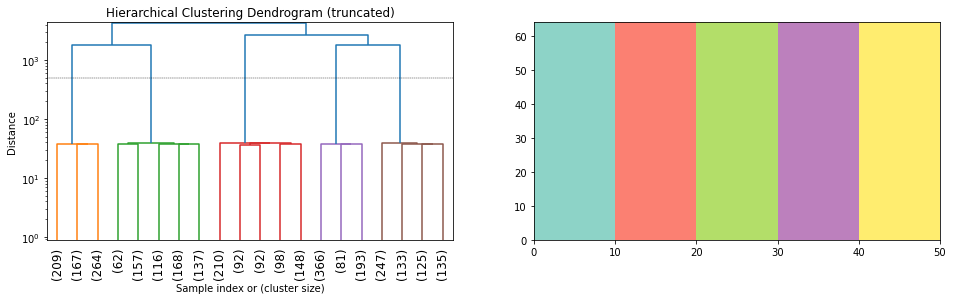

In [6]:
max_d   = 500 # Maximum distance to decide the number of clusters
nrow    = 2 
ncol    = 1
fig, ax = plt.subplots(ncol, nrow, figsize=(16, 4))

#---------------------------------------------------------------------------------------------------
# DENDOGRAM
#---------------------------------------------------------------------------------------------------
mm = 0
ax.flat[mm].set_title('Hierarchical Clustering Dendrogram (truncated)')
ax.flat[mm].set_xlabel('Sample index or (cluster size)')
ax.flat[mm].set_ylabel('Distance')
ax.flat[mm].set_yscale("log")

im = dendrogram(
        Z,
        ax=ax.flat[mm],
        truncate_mode='lastp',  # show only the last p merged clusters
        p=20,                   # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=12.,
        above_threshold_color='C0',
        color_threshold=max_d,
        show_contracted=False,  # to get a distribution impression in truncated branches
)
ax.flat[mm].axhline(max_d, color='black', lw=0.4, ls="dashed")

#---------------------------------------------------------------------------------------------------
# LABELS MAP FOR A GIVEN MAX_D
#---------------------------------------------------------------------------------------------------
mm = 1
clusters = fcluster(Z, max_d, criterion='distance')
clusters = clusters.reshape(raster_m.shape[0],raster_m.shape[1])
ax.flat[mm].pcolormesh(clusters,cmap="Set3")


plt.show()